### 0. Environment setup and reproducibility (Stage 2: Training pipeline)
- Seed the entire run for deterministic behavior (`seed_everything`).
- Load config (`scripts.config.Config`) to centralize paths, hyperparameters, and device preferences.
- Resolve device and AMP flags as per assignment GPU usage guidance.
- Create required directories for models and outputs.
- Print exact environment versions for auditability (Python, PyTorch, timm, sklearn, pandas, numpy) and resolved paths. This satisfies the requirement to enable reproducible results and clear logging in the notebook.


In [1]:
%matplotlib inline

from __future__ import annotations

import sys
from pathlib import Path
import json

import numpy as np
import pandas as pd
import sklearn
import torch
import timm
from tqdm.auto import tqdm

from scripts.config import Config
from scripts.utils import seed_everything, ensure_dirs

cfg = Config()
seed_everything(cfg.seed)

# Device detection
if cfg.device_preference == "cuda":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
elif cfg.device_preference == "cpu":
    device = torch.device("cpu")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

amp_enabled = (device.type == "cuda") and cfg.use_amp

# Derive safe DataLoader flags per device to avoid warnings and improve perf
use_pin_memory = bool((device.type == "cuda") and cfg.pin_memory)
persist_workers = bool(cfg.persistent_workers and cfg.num_workers > 0)

ensure_dirs(cfg.models_dir, cfg.outputs_dir, cfg.outputs_figs_dir)

print("=== Environment ===")
print(json.dumps({
    "python": sys.version.split()[0],
    "seed": cfg.seed,
    "pytorch": torch.__version__,
    "timm": timm.__version__,
    "sklearn": sklearn.__version__,
    "pandas": pd.__version__,
    "numpy": np.__version__,
    "device": str(device),
    "amp_enabled": amp_enabled,
    "dev_mode": cfg.dev_mode,
    "project_dir": str(cfg.project_dir),
    "data_dir": str(cfg.data_dir),
}, indent=2))


=== Environment ===
{
  "python": "3.10.12",
  "seed": 42,
  "pytorch": "2.8.0+cu128",
  "timm": "1.0.20",
  "sklearn": "1.7.2",
  "pandas": "2.3.2",
  "numpy": "2.2.6",
  "device": "cuda",
  "amp_enabled": true,
  "dev_mode": false,
  "project_dir": "/home/ubuntu/code/yandex_dl_course_4",
  "data_dir": "/home/ubuntu/code/yandex_dl_course_4/data"
}


### 1. Load dataset CSVs and validate schema (Stage 1: EDA)
- Read `data/dish.csv` and `data/ingredients.csv` from paths in config.
- Assert required columns exist as per assignment: dish metadata and ingredient vocabulary.
- Print row/column summaries for transparency before further processing.


In [2]:
# Load CSVs and assert required columns
required_dish_cols = {"dish_id", "total_calories", "total_mass", "ingredients", "split"}
required_ing_cols = {"id", "ingr"}

df_dish = pd.read_csv(cfg.dishes_csv)
df_ing = pd.read_csv(cfg.ingredients_csv)

missing_dish = required_dish_cols - set(df_dish.columns)
missing_ing = required_ing_cols - set(df_ing.columns)
if missing_dish or missing_ing:
    raise ValueError({"missing_dish_cols": sorted(missing_dish), "missing_ing_cols": sorted(missing_ing)})

print("=== CSV summary ===")
print(json.dumps({
    "dish_rows": len(df_dish),
    "ing_rows": len(df_ing),
    "dish_cols": sorted(df_dish.columns.tolist()),
    "ing_cols": sorted(df_ing.columns.tolist()),
}, indent=2))


=== CSV summary ===
{
  "dish_rows": 3262,
  "ing_rows": 555,
  "dish_cols": [
    "dish_id",
    "ingredients",
    "split",
    "total_calories",
    "total_mass"
  ],
  "ing_cols": [
    "id",
    "ingr"
  ]
}


### 2. Parse ingredient IDs to readable text (Stage 1: EDA)
- Build `id -> ingredient name` mapping from `ingredients.csv`.
- Parse and normalize ingredient tokens from `dish.csv` (`ingr_000...` → integer id → name).
- Lowercase, deduplicate per dish, and join into `ingredient_text` used by both EDA and text models.


In [3]:
# Parse ingredients and build ingredient_text
# Map id->name from ingredients.csv
id_to_name = dict(zip(df_ing["id"].astype(str), df_ing["ingr"].astype(str)))

# Parse ingredient ids per dish, normalize tokens like "ingr_0000000508" -> "508", map to names
import re

def parse_ids(s: str) -> list[str]:
    return [x.strip() for x in re.split(r"[;,]", str(s)) if x.strip()]

def normalize_ing_id(tok: str) -> str:
    m = re.match(r"^ingr_0*([0-9]+)$", tok)
    return m.group(1) if m else tok.strip()

def map_ids_to_names(ids: list[str]) -> list[str]:
    norm_ids = [normalize_ing_id(i) for i in ids]
    return [id_to_name[i] for i in norm_ids if i in id_to_name]

# Normalize: lowercase, deduplicate per dish, keep stable order

def normalize_tokens(tokens: list[str]) -> list[str]:
    seen = set()
    norm = []
    for t in (x.lower().strip() for x in tokens):
        if t and t not in seen:
            seen.add(t)
            norm.append(t)
    return norm

ids_list = df_dish["ingredients"].map(parse_ids)
name_list = ids_list.map(map_ids_to_names)
name_list = name_list.map(normalize_tokens)

df_dish["ingredient_text"] = name_list.map(lambda xs: " ".join(xs))

print("=== ingredient_text head ===")
print(df_dish[["dish_id", "ingredient_text"]].head().to_string(index=False))


=== ingredient_text head ===
        dish_id                                                                                                                                ingredient_text
dish_1561662216  soy sauce garlic white rice parsley onions brown rice vinegar apple mixed greens sugar salt lemon juice olive oil pork bok choy pepper millet
dish_1561662054 pepper white rice mixed greens garlic soy sauce millet lemon juice bok choy olive oil onions vinegar green beans pork apple sugar salt parsley
dish_1562008979                             jalapenos lemon juice pork wheat berry cabbage pepper salt carrot garlic caesar salad olive oil parsley mayonnaise
dish_1560455030                                                                                                         cherry tomatoes cucumbers baby carrots
dish_1558372433                                                                                                                                     deprecated


### 3. Verify image availability and filter dataset (Stage 1: EDA)
- Check that `data/images/<dish_id>/rgb.png` exists for each dish.
- Report kept vs removed counts; keep only rows with images to ensure downstream image models and fusion have valid inputs.


In [4]:
# Verify images exist; filter consistently; report counts
from pathlib import Path

img_path = []
exists = []
for did in tqdm(df_dish["dish_id"].astype(str), desc="verify_images", leave=False):
    p = cfg.images_dir / did / "rgb.png"
    img_path.append(p)
    exists.append(p.exists())

df_dish["image_path"] = img_path
df_dish["image_exists"] = exists

kept = df_dish[df_dish["image_exists"]].copy()
removed = df_dish[~df_dish["image_exists"]].copy()

print("=== Images availability ===")
print(json.dumps({
    "total": len(df_dish),
    "kept": len(kept),
    "removed": len(removed),
}, indent=2))

if len(removed) > 0:
    print("Missing image examples (first 5):")
    print(removed[["dish_id", "image_path"]].head().to_string(index=False))

# Keep only rows with images for all downstream steps
df_dish = kept.reset_index(drop=True)


verify_images:   0%|          | 0/3262 [00:00<?, ?it/s]

=== Images availability ===
{
  "total": 3262,
  "kept": 3262,
  "removed": 0
}


### 4. Respect provided split and summarize stats (Stage 1: EDA)
- Use the provided `split` column to create fixed train/test sets (no reshuffling).
- Print row counts and descriptive statistics for `total_calories` and `total_mass` per split, grounding later model expectations.


In [5]:
# Split by split column; print counts and basic stats

# Enforce no reshuffling: use provided split
assert set(str(x) for x in list(df_dish["split"])) <= {"train", "test"}

train_df = df_dish[df_dish["split"] == "train"].copy()
test_df = df_dish[df_dish["split"] == "test"].copy()

print("=== Split summary ===")
print(json.dumps({
    "train_rows": len(train_df),
    "test_rows": len(test_df),
}, indent=2))

for name, d in {"train": train_df, "test": test_df}.items():
    stats = {
        "total_calories": {
            "min": float(d["total_calories"].min()),
            "max": float(d["total_calories"].max()),
            "mean": float(d["total_calories"].mean()),
            "std": float(d["total_calories"].std()),
        },
        "total_mass": {
            "min": float(d["total_mass"].min()),
            "max": float(d["total_mass"].max()),
            "mean": float(d["total_mass"].mean()),
            "std": float(d["total_mass"].std()),
        },
    }
    print(f"=== Stats ({name}) ===")
    print(json.dumps(stats, indent=2))


=== Split summary ===
{
  "train_rows": 2755,
  "test_rows": 507
}
=== Stats (train) ===
{
  "total_calories": {
    "min": 0.0,
    "max": 3943.325195,
    "mean": 254.92913137749548,
    "std": 221.00905125247766
  },
  "total_mass": {
    "min": 5.0,
    "max": 3051.0,
    "mean": 218.01125226860253,
    "std": 163.08950348765637
  }
}
=== Stats (test) ===
{
  "total_calories": {
    "min": 0.0,
    "max": 1050.511108,
    "mean": 255.46705058777118,
    "std": 212.24167359858788
  },
  "total_mass": {
    "min": 1.0,
    "max": 871.0,
    "mean": 198.50887573964496,
    "std": 151.65256155764206
  }
}


### 5. EDA plots and ingredient frequency (Stage 1: EDA)
- Plot histogram+KDE of `total_calories` and scatter `total_mass` vs `total_calories` with Pearson r.
- Compute Top-N ingredient frequencies from `ingredient_text` for intuition about vocabulary distribution.


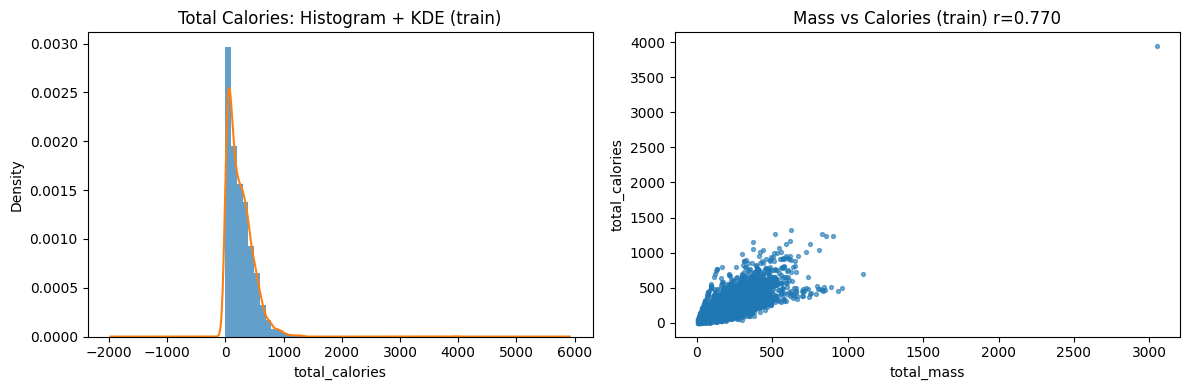

count_ingredients:   0%|          | 0/2755 [00:00<?, ?it/s]

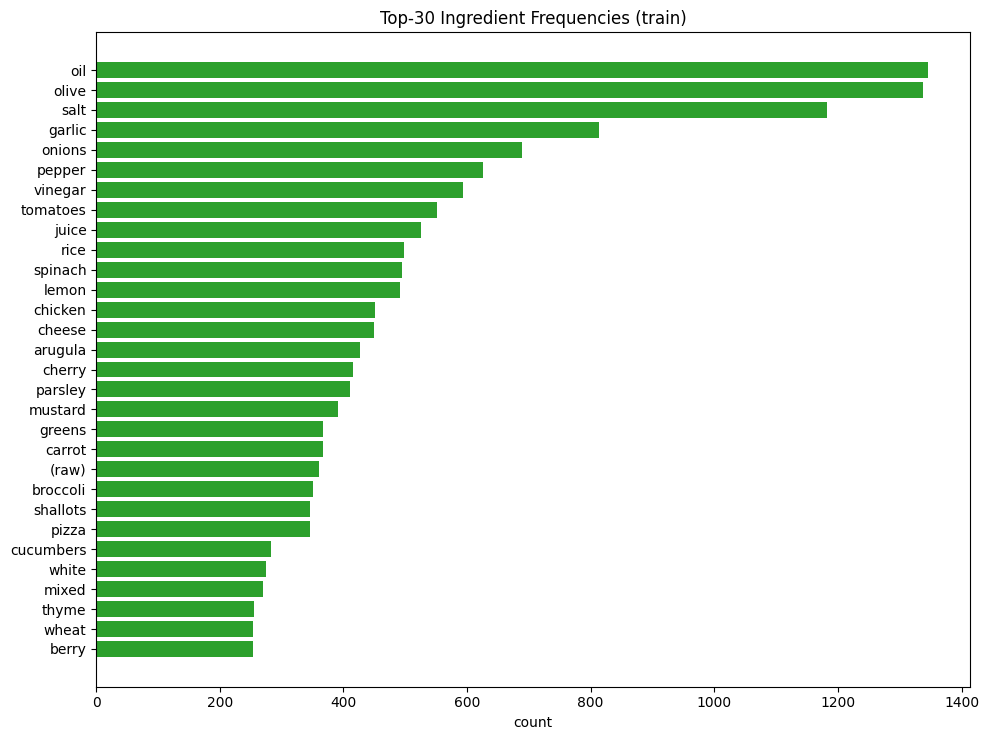

=== EDA summary ===
{
  "pearson_r": 0.7699333350035942,
  "pearson_p": 0.0
}


In [6]:
# Plots: histogram/KDE, mass vs calories with Pearson r, top-N ingredients
import math
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import pearsonr


# Histogram + KDE (total_calories)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].hist(train_df["total_calories"], bins=40, alpha=0.7, color="tab:blue", density=True)
train_df["total_calories"].plot(kind="kde", ax=ax[0], color="tab:orange")
ax[0].set_title("Total Calories: Histogram + KDE (train)")
ax[0].set_xlabel("total_calories")

# Mass vs calories with Pearson r
r, p = pearsonr(train_df["total_mass"].to_numpy(), train_df["total_calories"].to_numpy())
ax[1].scatter(train_df["total_mass"], train_df["total_calories"], s=8, alpha=0.6)
ax[1].set_title(f"Mass vs Calories (train) r={r:.3f}")
ax[1].set_xlabel("total_mass")
ax[1].set_ylabel("total_calories")
fig.tight_layout()
plt.show()
plt.close(fig)

# Top-N ingredient frequencies (train)
N = 30
all_tokens = []
for text in tqdm(train_df["ingredient_text"].astype(str), desc="count_ingredients", leave=False):
    all_tokens.extend([t for t in text.split() if t])

counts = Counter(all_tokens)
common = counts.most_common(N)

fig, ax = plt.subplots(figsize=(10, max(5, N * 0.25)))
ax.barh([w for w, _ in reversed(common)], [c for _, c in reversed(common)], color="tab:green")
ax.set_title(f"Top-{N} Ingredient Frequencies (train)")
ax.set_xlabel("count")
fig.tight_layout()
plt.show()
plt.close(fig)

print("=== EDA summary ===")
print(json.dumps({
    "pearson_r": float(r),
    "pearson_p": float(p),
}, indent=2))


### 6. Visual sample grid (Stage 1: EDA)
- Randomly sample dishes from train split.
- Show image thumbnails with calories and a short ingredient snippet to qualitatively inspect data.


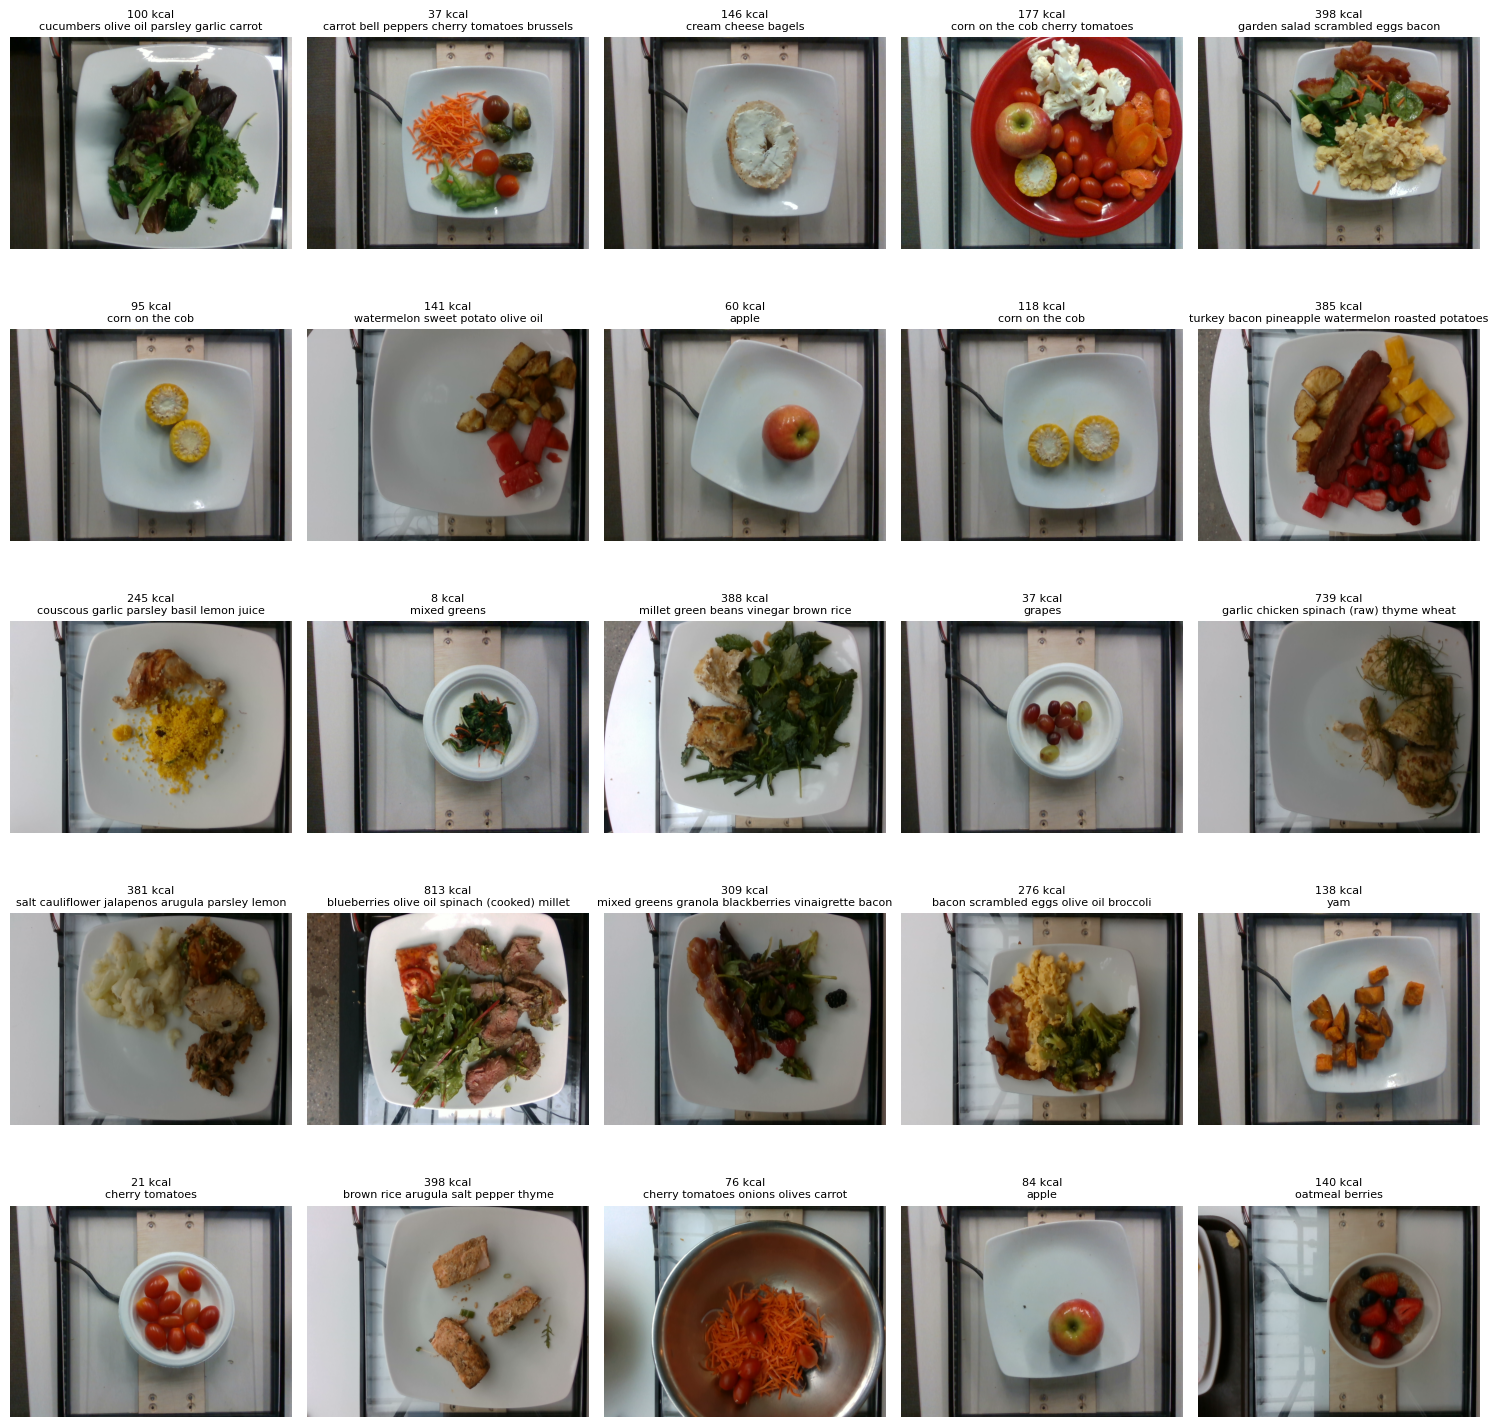

=== Sample grid ===
{
  "grid_saved": true,
  "num_samples": 25
}


In [7]:
# Save a grid of sample images with ingredient text and total_calories
import math
import matplotlib.pyplot as plt
from PIL import Image


rows_list = list(train_df.itertuples(index=False))
k = int(min(25, len(rows_list)))
idx = np.arange(len(rows_list))
rng = np.random.default_rng(cfg.seed)
rng.shuffle(idx)
selected_idx = idx[:k].tolist()
selected = [rows_list[i] for i in selected_idx]

cols = 5
rows = math.ceil(k / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
axes = axes.flatten()

for ax, row in zip(axes, selected):
    img = Image.open(str(row.image_path)).convert("RGB")
    ax.imshow(img)
    short_ing = " ".join(str(row.ingredient_text).split()[:6])
    ax.set_title(f"{row.total_calories:.0f} kcal\n{short_ing}", fontsize=8)
    ax.axis("off")

for ax in axes[k:]:
    ax.axis("off")

fig.tight_layout()
plt.show()
plt.close(fig)

print("=== Sample grid ===")
print(json.dumps({"grid_saved": True, "num_samples": k}, indent=2))


### 7. Image transforms from scripts (Stage 2: Training pipeline)
- Import and instantiate train/eval transforms from `scripts/dataset.py` per backbone and image size.
- Display transform pipelines for transparent preprocessing configuration.


In [8]:
# Define train/eval transforms using scripts/dataset.py
from scripts.dataset import build_train_transforms, build_eval_transforms

train_tfms = build_train_transforms(cfg.backbone, cfg.image_size)
eval_tfms = build_eval_transforms(cfg.backbone, cfg.image_size)

from IPython.display import Markdown, display
md = (
    f"### Transforms\n\n"
    f"- Train\n```text\n{train_tfms}\n```\n"
    f"- Eval\n```text\n{eval_tfms}\n```"
)
display(Markdown(md))


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

### Transforms

- Train
```text
Compose(
    RandomResizedCropAndInterpolation(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bicubic)
    RandomHorizontalFlip(p=0.5)
    ColorJitter(brightness=(0.6, 1.4), contrast=(0.6, 1.4), saturation=(0.6, 1.4), hue=None)
    MaybeToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)
```
- Eval
```text
Compose(
    Resize(size=256, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    MaybeToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)
```

### 8. Build `DataLoader`s and MAE criterion (Stage 2: Training pipeline)
- Create `ImageDataset` for train/test with transforms.
- Configure `DataLoader`s with device-aware flags.
- Use `L1Loss` (MAE) aligned with the assignment’s target metric.


In [9]:
# Create DataLoaders; use L1Loss (MAE) and AdamW (optimizer in 3.5); AMP flag present
from torch.utils.data import DataLoader
from scripts.dataset import ImageDataset

train_ds = ImageDataset(train_df, cfg.images_dir, transform=train_tfms)
test_ds = ImageDataset(test_df, cfg.images_dir, transform=eval_tfms)

train_loader = DataLoader(
    train_ds,
    batch_size=cfg.batch_size,
    shuffle=True,
    num_workers=cfg.num_workers,
    pin_memory=use_pin_memory,
    persistent_workers=persist_workers,
)

test_loader = DataLoader(
    test_ds,
    batch_size=cfg.batch_size,
    shuffle=False,
    num_workers=cfg.num_workers,
    pin_memory=use_pin_memory,
    persistent_workers=persist_workers,
)

criterion = torch.nn.L1Loss()
print("=== DataLoaders ===")
print(json.dumps({
    "train_batches": len(train_loader),
    "test_batches": len(test_loader),
    "amp_enabled": amp_enabled,
}, indent=2))


=== DataLoaders ===
{
  "train_batches": 87,
  "test_batches": 16,
  "amp_enabled": true
}


### 9. Train image baseline and save best checkpoint (Stage 3: Training)
- Instantiate `ImageBackbone` and infer feature dim from a sample batch.
- Build `ImageRegressor` head; optimize with AdamW and MAE loss.
- Train for configured epochs; validate each epoch; track MAE.
- Save best model weights to `models/best_image.pt` when validation MAE improves.


In [10]:
# Train baseline; log epoch metrics; save best checkpoint
from scripts.utils import ImageBackbone, ImageRegressor, train_one_epoch, validate, save_best_checkpoint

backbone = ImageBackbone(cfg.backbone).to(device)
# Feature dimension inferred by running a single batch through backbone
with torch.inference_mode():
    sample = next(iter(train_loader))[0][:2].to(device)
    feat_dim = backbone(sample).shape[1]

head = ImageRegressor(in_features=int(feat_dim)).to(device)
params = list(head.parameters()) + list(backbone.parameters())
optimizer = torch.optim.AdamW(params, lr=cfg.learning_rate, weight_decay=cfg.weight_decay)

best_val_mae = float("inf")
max_epochs = (cfg.dev_epochs if cfg.dev_mode else cfg.epochs)
max_train_batches = (cfg.dev_max_train_batches if cfg.dev_mode else None)
max_val_batches = (cfg.dev_max_val_batches if cfg.dev_mode else None)
for epoch in range(1, max_epochs + 1):
    train_loss = train_one_epoch(
        model=head,
        feature_extractor=backbone,
        dataloader=train_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        amp_enabled=amp_enabled,
        max_grad_norm=cfg.grad_clip_norm,
        max_batches=max_train_batches,
    )
    val_loss, metrics = validate(
        model=head,
        feature_extractor=backbone,
        dataloader=test_loader,
        criterion=criterion,
        device=device,
        max_batches=max_val_batches,
    )
    print("=== Image training epoch ===")
    print(json.dumps({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss, **metrics}, indent=2))
    if metrics["MAE"] < best_val_mae:
        best_val_mae = metrics["MAE"]
        save_best_checkpoint(head.state_dict(), optimizer.state_dict(), epoch, cfg.best_image_ckpt)
        print("=== Image best updated ===")
        print(json.dumps({"best_updated": True, "best_mae": best_val_mae, "epoch": epoch, "path": str(cfg.best_image_ckpt)}, indent=2))


train:   0%|          | 0/87 [00:00<?, ?it/s]

validate:   0%|          | 0/16 [00:00<?, ?it/s]

=== Image training epoch ===
{
  "epoch": 1,
  "train_loss": 225.8244802069967,
  "val_loss": 124.61728776559322,
  "MAE": 124.61728933288971,
  "RMSE": 189.82695088809052,
  "R2": 0.1984846146293745
}
=== Image best updated ===
{
  "best_updated": true,
  "best_mae": 124.61728933288971,
  "epoch": 1,
  "path": "/home/ubuntu/code/yandex_dl_course_4/models/best_image.pt"
}


train:   0%|          | 0/87 [00:00<?, ?it/s]

validate:   0%|          | 0/16 [00:00<?, ?it/s]

=== Image training epoch ===
{
  "epoch": 2,
  "train_loss": 130.1691103843509,
  "val_loss": 90.38163148627949,
  "MAE": 90.38163139217,
  "RMSE": 135.70794234305674,
  "R2": 0.5903559505558343
}
=== Image best updated ===
{
  "best_updated": true,
  "best_mae": 90.38163139217,
  "epoch": 2,
  "path": "/home/ubuntu/code/yandex_dl_course_4/models/best_image.pt"
}


train:   0%|          | 0/87 [00:00<?, ?it/s]

validate:   0%|          | 0/16 [00:00<?, ?it/s]

=== Image training epoch ===
{
  "epoch": 3,
  "train_loss": 103.10398963886684,
  "val_loss": 79.84487740480924,
  "MAE": 79.84487957185542,
  "RMSE": 120.03902566795753,
  "R2": 0.67949039954818
}
=== Image best updated ===
{
  "best_updated": true,
  "best_mae": 79.84487957185542,
  "epoch": 3,
  "path": "/home/ubuntu/code/yandex_dl_course_4/models/best_image.pt"
}


train:   0%|          | 0/87 [00:00<?, ?it/s]

validate:   0%|          | 0/16 [00:00<?, ?it/s]

=== Image training epoch ===
{
  "epoch": 4,
  "train_loss": 96.28692735509301,
  "val_loss": 81.76040440245258,
  "MAE": 81.76040534154903,
  "RMSE": 121.0317890345268,
  "R2": 0.6741670314441524
}


train:   0%|          | 0/87 [00:00<?, ?it/s]

validate:   0%|          | 0/16 [00:00<?, ?it/s]

=== Image training epoch ===
{
  "epoch": 5,
  "train_loss": 94.73992803057828,
  "val_loss": 83.99260117269361,
  "MAE": 83.99260138125109,
  "RMSE": 123.26802673665173,
  "R2": 0.6620153262692998
}


train:   0%|          | 0/87 [00:00<?, ?it/s]

validate:   0%|          | 0/16 [00:00<?, ?it/s]

=== Image training epoch ===
{
  "epoch": 6,
  "train_loss": 90.09528035407924,
  "val_loss": 70.82114098904401,
  "MAE": 70.82114000409783,
  "RMSE": 104.41795707833694,
  "R2": 0.7574805897250114
}
=== Image best updated ===
{
  "best_updated": true,
  "best_mae": 70.82114000409783,
  "epoch": 6,
  "path": "/home/ubuntu/code/yandex_dl_course_4/models/best_image.pt"
}


train:   0%|          | 0/87 [00:00<?, ?it/s]

validate:   0%|          | 0/16 [00:00<?, ?it/s]

=== Image training epoch ===
{
  "epoch": 7,
  "train_loss": 89.22693981025266,
  "val_loss": 84.89365611932216,
  "MAE": 84.893655787088,
  "RMSE": 119.95763029775618,
  "R2": 0.6799249107854594
}


train:   0%|          | 0/87 [00:00<?, ?it/s]

validate:   0%|          | 0/16 [00:00<?, ?it/s]

=== Image training epoch ===
{
  "epoch": 8,
  "train_loss": 85.81650803249241,
  "val_loss": 68.20257660905285,
  "MAE": 68.20257621991799,
  "RMSE": 98.16994014154668,
  "R2": 0.7856353487246909
}
=== Image best updated ===
{
  "best_updated": true,
  "best_mae": 68.20257621991799,
  "epoch": 8,
  "path": "/home/ubuntu/code/yandex_dl_course_4/models/best_image.pt"
}


train:   0%|          | 0/87 [00:00<?, ?it/s]

validate:   0%|          | 0/16 [00:00<?, ?it/s]

=== Image training epoch ===
{
  "epoch": 9,
  "train_loss": 82.2523585158554,
  "val_loss": 69.28801824355267,
  "MAE": 69.2880184281272,
  "RMSE": 102.79813353722443,
  "R2": 0.7649465779680029
}


train:   0%|          | 0/87 [00:00<?, ?it/s]

validate:   0%|          | 0/16 [00:00<?, ?it/s]

=== Image training epoch ===
{
  "epoch": 10,
  "train_loss": 80.92006513592119,
  "val_loss": 66.47868004070936,
  "MAE": 66.47868123915069,
  "RMSE": 95.9743896330914,
  "R2": 0.795116569573213
}
=== Image best updated ===
{
  "best_updated": true,
  "best_mae": 66.47868123915069,
  "epoch": 10,
  "path": "/home/ubuntu/code/yandex_dl_course_4/models/best_image.pt"
}


### 10. Evaluate image baseline on test and save predictions (Stage 4: Validation)
- Load best image checkpoint and run inference on test.
- Compute MAE/RMSE/R².
- Save per‑dish predictions to `outputs/preds_image.csv` for analysis.


In [11]:
# Evaluate on test; compute MAE/RMSE/R²; save outputs/preds_image.csv
from scripts.utils import evaluate_metrics

# Load best checkpoint for image baseline
ckpt = torch.load(cfg.best_image_ckpt, map_location=device)
head.load_state_dict(ckpt["model"])

backbone.eval(); head.eval()
all_true = []
all_pred = []
all_ids = []
with torch.inference_mode():
    for images, targets, dish_ids in tqdm(test_loader, desc="eval_image", leave=False):
        images = images.to(device, non_blocking=True)
        preds = head(backbone(images))
        all_true.extend(targets.numpy().tolist())
        all_pred.extend(preds.cpu().numpy().tolist())
        all_ids.extend([str(x) for x in dish_ids])

metrics = evaluate_metrics(np.asarray(all_true), np.asarray(all_pred))
print("=== Image test metrics ===")
print(json.dumps(metrics, indent=2))

# Save predictions CSV
from pathlib import Path
ensure_dirs(cfg.outputs_dir)
import csv
preds_path = cfg.outputs_dir / "preds_image.csv"
with open(preds_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["dish_id", "y_true", "y_pred", "abs_err"])
    for did, y, yhat in zip(all_ids, all_true, all_pred):
        writer.writerow([did, y, yhat, abs(y - yhat)])
print("=== Image preds path ===")
print(json.dumps({"path": str(preds_path)}, indent=2))


eval_image:   0%|          | 0/16 [00:00<?, ?it/s]

=== Image test metrics ===
{
  "MAE": 66.47868123915069,
  "RMSE": 95.9743896330914,
  "R2": 0.795116569573213
}
=== Image preds path ===
{
  "path": "/home/ubuntu/code/yandex_dl_course_4/outputs/preds_image.csv"
}


### 11. Prepare text: normalize `ingredient_text` (Stage 2→4: Text pipeline)
- Lowercase and deduplicate tokens per dish to stabilize vocabulary.
- Update `ingredient_text` for train/test splits; preview examples.


In [12]:
# Build per-dish ingredient_text for train/test; lowercase; deduplicate

def dedup_lower(text: str) -> str:
    seen = set()
    out = []
    for t in str(text).lower().split():
        if t and t not in seen:
            seen.add(t)
            out.append(t)
    return " ".join(out)

train_df["ingredient_text"] = train_df["ingredient_text"].astype(str).map(dedup_lower)
test_df["ingredient_text"] = test_df["ingredient_text"].astype(str).map(dedup_lower)

print("=== ingredient_text examples (train) ===")
print(json.dumps(train_df["ingredient_text"].head().tolist()[:3], indent=2))


=== ingredient_text examples (train) ===
[
  "pepper white rice mixed greens garlic soy sauce millet lemon juice bok choy olive oil onions vinegar green beans pork apple sugar salt parsley",
  "cherry tomatoes cucumbers baby carrots",
  "deprecated"
]


### 12. Fit TF‑IDF on train and transform test (Stage 2→4: Text pipeline)
- Configure `TfidfVectorizer` hyperparameters from config.
- Fit on train `ingredient_text`, transform both train/test.
- Print sparse matrix shapes for sanity.


In [13]:
# Fit TF-IDF on train; transform train/test
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(
    min_df=cfg.tfidf_min_df,
    max_df=cfg.tfidf_max_df,
    max_features=cfg.tfidf_max_features,
    norm=cfg.tfidf_norm,
    use_idf=cfg.tfidf_use_idf,
    sublinear_tf=cfg.tfidf_sublinear_tf,
)

X_train = vec.fit_transform(train_df["ingredient_text"].astype(str).tolist())
X_test = vec.transform(test_df["ingredient_text"].astype(str).tolist())

print("=== TF-IDF shapes ===")
print(json.dumps({"X_train_shape": list(X_train.shape), "X_test_shape": list(X_test.shape)}, indent=2))


=== TF-IDF shapes ===
{
  "X_train_shape": [
    2755,
    202
  ],
  "X_test_shape": [
    507,
    202
  ]
}


### 13. Train TF‑IDF Ridge regressor and evaluate (Stage 4: Validation)
- Train `Ridge` on TF‑IDF features to predict calories.
- Report test MAE/RMSE/R²; this is a strong text‑only baseline.


In [14]:
# Train Ridge regressor on TF-IDF features; evaluate
from sklearn.linear_model import Ridge
from scripts.utils import evaluate_metrics

ridge = Ridge(alpha=1.0, random_state=cfg.seed)
ridge.fit(X_train, train_df["total_calories"].to_numpy())

y_pred = ridge.predict(X_test)
metrics_tfidf = evaluate_metrics(test_df["total_calories"].to_numpy(), y_pred)
print("=== TF-IDF test metrics ===")
print(json.dumps(metrics_tfidf, indent=2))


=== TF-IDF test metrics ===
{
  "MAE": 106.23877097208228,
  "RMSE": 153.15917046996012,
  "R2": 0.47822636528209317
}


### 14. Save TF‑IDF predictions (Stage 4: Validation)
- Write per‑dish predictions from the TF‑IDF Ridge model to `outputs/preds_tfidf.csv` for later comparison.


In [15]:
# Save TF-IDF predictions to outputs/preds_tfidf.csv
ensure_dirs(cfg.outputs_dir)
import csv
preds_tfidf_path = cfg.outputs_dir / "preds_tfidf.csv"
with open(preds_tfidf_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["dish_id", "y_true", "y_pred", "abs_err"])
    for did, y, yhat in zip(test_df["dish_id"].tolist(), test_df["total_calories"].to_numpy().tolist(), y_pred.tolist()):
        writer.writerow([did, y, yhat, abs(y - yhat)])
print("=== TF-IDF preds path ===")
print(json.dumps({"path": str(preds_tfidf_path)}, indent=2))


=== TF-IDF preds path ===
{
  "path": "/home/ubuntu/code/yandex_dl_course_4/outputs/preds_tfidf.csv"
}


### 15. Persist TF‑IDF vectorizer (optional artifact) (Stage 2→4)
- Save fitted `TfidfVectorizer` to `outputs/tfidf_vectorizer.pkl` for reproducible inference and audit.


In [16]:
# Save TF-IDF vectorizer
import pickle
ensure_dirs(cfg.outputs_dir)
with open(cfg.outputs_dir / "tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vec, f)
print("=== TF-IDF vectorizer path ===")
print(json.dumps({"path": str(cfg.outputs_dir / "tfidf_vectorizer.pkl")}, indent=2))


=== TF-IDF vectorizer path ===
{
  "path": "/home/ubuntu/code/yandex_dl_course_4/outputs/tfidf_vectorizer.pkl"
}


### 16. Build fusion datasets (image + TF‑IDF) (Stage 2→5: Fusion)
- Construct `FusionDataset` to pair each image with its TF‑IDF row by `dish_id`.
- Create id→row mappings for train/test TF‑IDF matrices; report dataset sizes.


In [17]:
# FusionDataset usage; align by dish_id; precompute TF-IDF matrix and mapping
from scripts.dataset import FusionDataset

# Build mapping from dish_id (str) to row index in TF-IDF matrix for train/test
train_ids = train_df["dish_id"].astype(str).tolist()
test_ids = test_df["dish_id"].astype(str).tolist()

id_to_row_train = {did: i for i, did in enumerate(train_ids)}
id_to_row_test = {did: i for i, did in enumerate(test_ids)}

fusion_train = FusionDataset(
    df=train_df,
    images_dir=cfg.images_dir,
    transform=train_tfms,
    tfidf_matrix=X_train,
    id_to_row=id_to_row_train,
)

fusion_test = FusionDataset(
    df=test_df,
    images_dir=cfg.images_dir,
    transform=eval_tfms,
    tfidf_matrix=X_test,
    id_to_row=id_to_row_test,
)

print("=== Fusion datasets ===")
print(json.dumps({"fusion_train_len": len(fusion_train), "fusion_test_len": len(fusion_test)}, indent=2))


=== Fusion datasets ===
{
  "fusion_train_len": 2755,
  "fusion_test_len": 507
}


### 17. Train fusion model and save best (Stage 3→5: Fusion)
- Freeze the image backbone to stabilize and reduce compute.
- Infer image/tfidf dims; build `FusionRegressor` that projects and fuses modalities.
- Train/validate with MAE; save best weights to `models/best.pt` on MAE improvement.


In [18]:
# Train fusion model (freeze or lightly unfreeze backbone); L1Loss; save best to models/best.pt
from torch.utils.data import DataLoader
from scripts.utils import FusionRegressor, train_one_epoch_fusion, validate_fusion

# Freeze backbone by default for fusion
backbone_fusion = ImageBackbone(cfg.backbone).to(device)
for p in backbone_fusion.parameters():
    p.requires_grad = False

# Infer dims
with torch.inference_mode():
    sample = next(iter(train_loader))[0][:2].to(device)
    img_dim = backbone_fusion(sample).shape[1]
    tfidf_dim = X_train.shape[1]

fusion_head = FusionRegressor(
    image_in_features=int(img_dim),
    tfidf_in_features=int(tfidf_dim),
    projection_dim=512,
    hidden_features=512,
).to(device)

fusion_train_loader = DataLoader(
    fusion_train,
    batch_size=cfg.batch_size,
    shuffle=True,
    num_workers=cfg.num_workers,
    pin_memory=use_pin_memory,
    persistent_workers=persist_workers,
)

fusion_test_loader = DataLoader(
    fusion_test,
    batch_size=cfg.batch_size,
    shuffle=False,
    num_workers=cfg.num_workers,
    pin_memory=use_pin_memory,
    persistent_workers=persist_workers,
)

optimizer_fusion = torch.optim.AdamW(fusion_head.parameters(), lr=cfg.learning_rate, weight_decay=cfg.weight_decay)

best_val_mae = float("inf")
max_epochs = (cfg.dev_epochs if cfg.dev_mode else cfg.epochs)
max_train_batches = (cfg.dev_max_train_batches if cfg.dev_mode else None)
max_val_batches = (cfg.dev_max_val_batches if cfg.dev_mode else None)
for epoch in range(1, max_epochs + 1):
    train_loss = train_one_epoch_fusion(
        model=fusion_head,
        feature_extractor=backbone_fusion,
        dataloader=fusion_train_loader,
        criterion=criterion,
        optimizer=optimizer_fusion,
        device=device,
        amp_enabled=amp_enabled,
        max_grad_norm=cfg.grad_clip_norm,
        max_batches=max_train_batches,
    )
    val_loss, metrics = validate_fusion(
        model=fusion_head,
        feature_extractor=backbone_fusion,
        dataloader=fusion_test_loader,
        criterion=criterion,
        device=device,
        max_batches=max_val_batches,
    )
    print("=== Fusion training epoch ===")
    epoch_payload = {"epoch": epoch, "fusion_train_loss": train_loss, "fusion_val_loss": val_loss}
    epoch_payload.update({f"fusion_{k}": v for k, v in metrics.items()})
    print(json.dumps(epoch_payload, indent=2))
    if metrics["MAE"] < best_val_mae:
        best_val_mae = metrics["MAE"]
        save_best_checkpoint(fusion_head.state_dict(), optimizer_fusion.state_dict(), epoch, cfg.best_ckpt)
        print("=== Fusion best updated ===")
        print(json.dumps({"fusion_best_updated": True, "fusion_best_mae": best_val_mae, "epoch": epoch, "path": str(cfg.best_ckpt)}, indent=2))


train_fusion:   0%|          | 0/87 [00:00<?, ?it/s]

validate_fusion:   0%|          | 0/16 [00:00<?, ?it/s]

=== Fusion training epoch ===
{
  "epoch": 1,
  "fusion_train_loss": 221.40650543932907,
  "fusion_val_loss": 190.3569828913762,
  "fusion_MAE": 190.35698266571325,
  "fusion_RMSE": 242.03834883972348,
  "fusion_R2": -0.30306020720571203
}
=== Fusion best updated ===
{
  "fusion_best_updated": true,
  "fusion_best_mae": 190.35698266571325,
  "epoch": 1,
  "path": "/home/ubuntu/code/yandex_dl_course_4/models/best.pt"
}


train_fusion:   0%|          | 0/87 [00:00<?, ?it/s]

validate_fusion:   0%|          | 0/16 [00:00<?, ?it/s]

=== Fusion training epoch ===
{
  "epoch": 2,
  "fusion_train_loss": 163.39344131829733,
  "fusion_val_loss": 162.27799017189523,
  "fusion_MAE": 162.2779885591605,
  "fusion_RMSE": 218.63708913279913,
  "fusion_R2": -0.06327056855093982
}
=== Fusion best updated ===
{
  "fusion_best_updated": true,
  "fusion_best_mae": 162.2779885591605,
  "epoch": 2,
  "path": "/home/ubuntu/code/yandex_dl_course_4/models/best.pt"
}


train_fusion:   0%|          | 0/87 [00:00<?, ?it/s]

validate_fusion:   0%|          | 0/16 [00:00<?, ?it/s]

=== Fusion training epoch ===
{
  "epoch": 3,
  "fusion_train_loss": 140.01335803687897,
  "fusion_val_loss": 134.23328100200706,
  "fusion_MAE": 134.23328094322537,
  "fusion_RMSE": 192.4685401509717,
  "fusion_R2": 0.1760219855444477
}
=== Fusion best updated ===
{
  "fusion_best_updated": true,
  "fusion_best_mae": 134.23328094322537,
  "epoch": 3,
  "path": "/home/ubuntu/code/yandex_dl_course_4/models/best.pt"
}


train_fusion:   0%|          | 0/87 [00:00<?, ?it/s]

validate_fusion:   0%|          | 0/16 [00:00<?, ?it/s]

=== Fusion training epoch ===
{
  "epoch": 4,
  "fusion_train_loss": 123.21990400753955,
  "fusion_val_loss": 122.71197628645737,
  "fusion_MAE": 122.71197615784301,
  "fusion_RMSE": 182.21230519843007,
  "fusion_R2": 0.261498257473724
}
=== Fusion best updated ===
{
  "fusion_best_updated": true,
  "fusion_best_mae": 122.71197615784301,
  "epoch": 4,
  "path": "/home/ubuntu/code/yandex_dl_course_4/models/best.pt"
}


train_fusion:   0%|          | 0/87 [00:00<?, ?it/s]

validate_fusion:   0%|          | 0/16 [00:00<?, ?it/s]

=== Fusion training epoch ===
{
  "epoch": 5,
  "fusion_train_loss": 114.87802015605726,
  "fusion_val_loss": 111.73297286174706,
  "fusion_MAE": 111.73297247637423,
  "fusion_RMSE": 166.82360497239335,
  "fusion_R2": 0.3809708176221267
}
=== Fusion best updated ===
{
  "fusion_best_updated": true,
  "fusion_best_mae": 111.73297247637423,
  "epoch": 5,
  "path": "/home/ubuntu/code/yandex_dl_course_4/models/best.pt"
}


train_fusion:   0%|          | 0/87 [00:00<?, ?it/s]

validate_fusion:   0%|          | 0/16 [00:00<?, ?it/s]

=== Fusion training epoch ===
{
  "epoch": 6,
  "fusion_train_loss": 109.41227853432325,
  "fusion_val_loss": 104.33222639396111,
  "fusion_MAE": 104.33222851033747,
  "fusion_RMSE": 152.66404185361677,
  "fusion_R2": 0.48159446228733227
}
=== Fusion best updated ===
{
  "fusion_best_updated": true,
  "fusion_best_mae": 104.33222851033747,
  "epoch": 6,
  "path": "/home/ubuntu/code/yandex_dl_course_4/models/best.pt"
}


train_fusion:   0%|          | 0/87 [00:00<?, ?it/s]

validate_fusion:   0%|          | 0/16 [00:00<?, ?it/s]

=== Fusion training epoch ===
{
  "epoch": 7,
  "fusion_train_loss": 101.40994439099099,
  "fusion_val_loss": 103.06853901187814,
  "fusion_MAE": 103.06853564885947,
  "fusion_RMSE": 154.95571790908878,
  "fusion_R2": 0.4659138298397554
}
=== Fusion best updated ===
{
  "fusion_best_updated": true,
  "fusion_best_mae": 103.06853564885947,
  "epoch": 7,
  "path": "/home/ubuntu/code/yandex_dl_course_4/models/best.pt"
}


train_fusion:   0%|          | 0/87 [00:00<?, ?it/s]

validate_fusion:   0%|          | 0/16 [00:00<?, ?it/s]

=== Fusion training epoch ===
{
  "epoch": 8,
  "fusion_train_loss": 99.8823937833201,
  "fusion_val_loss": 98.92598033656735,
  "fusion_MAE": 98.92597876615542,
  "fusion_RMSE": 149.1563846179752,
  "fusion_R2": 0.5051428889413673
}
=== Fusion best updated ===
{
  "fusion_best_updated": true,
  "fusion_best_mae": 98.92597876615542,
  "epoch": 8,
  "path": "/home/ubuntu/code/yandex_dl_course_4/models/best.pt"
}


train_fusion:   0%|          | 0/87 [00:00<?, ?it/s]

validate_fusion:   0%|          | 0/16 [00:00<?, ?it/s]

=== Fusion training epoch ===
{
  "epoch": 9,
  "fusion_train_loss": 94.96166116537935,
  "fusion_val_loss": 94.53218152349046,
  "fusion_MAE": 94.53217981764551,
  "fusion_RMSE": 142.58350378658574,
  "fusion_R2": 0.5477957030897365
}
=== Fusion best updated ===
{
  "fusion_best_updated": true,
  "fusion_best_mae": 94.53217981764551,
  "epoch": 9,
  "path": "/home/ubuntu/code/yandex_dl_course_4/models/best.pt"
}


train_fusion:   0%|          | 0/87 [00:00<?, ?it/s]

validate_fusion:   0%|          | 0/16 [00:00<?, ?it/s]

=== Fusion training epoch ===
{
  "epoch": 10,
  "fusion_train_loss": 93.33325347069604,
  "fusion_val_loss": 91.02161002676398,
  "fusion_MAE": 91.02161082548973,
  "fusion_RMSE": 136.39701020672516,
  "fusion_R2": 0.5861853887481276
}
=== Fusion best updated ===
{
  "fusion_best_updated": true,
  "fusion_best_mae": 91.02161082548973,
  "epoch": 10,
  "path": "/home/ubuntu/code/yandex_dl_course_4/models/best.pt"
}


### Evaluate fusion model and save predictions (Stage 4: Validation)
- Load best fusion checkpoint and evaluate on test split.
- Compute MAE/RMSE/R²; save `outputs/preds.csv` for downstream error analysis.


In [19]:
# Evaluate fusion on test; save outputs/preds.csv
from scripts.utils import evaluate_metrics

# Load best checkpoint for fusion model
ckpt = torch.load(cfg.best_ckpt, map_location=device)
fusion_head.load_state_dict(ckpt["model"])

backbone_fusion.eval(); fusion_head.eval()
all_true = []
all_pred = []
all_ids = []
with torch.inference_mode():
    for images, targets, tfidf_vecs, dish_ids in tqdm(fusion_test_loader, desc="eval_fusion", leave=False):
        images = images.to(device, non_blocking=True)
        tfidf_vecs_t = torch.as_tensor(tfidf_vecs, dtype=torch.float32, device=device)
        preds = fusion_head(backbone_fusion(images), tfidf_vecs_t)
        all_true.extend(targets.numpy().tolist())
        all_pred.extend(preds.cpu().numpy().tolist())
        all_ids.extend([str(x) for x in dish_ids])

fusion_metrics = evaluate_metrics(np.asarray(all_true), np.asarray(all_pred))
print("=== Fusion test metrics ===")
print(json.dumps(fusion_metrics, indent=2))

# Save predictions CSV
ensure_dirs(cfg.outputs_dir)
import csv
preds_fusion_path = cfg.outputs_dir / "preds.csv"
with open(preds_fusion_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["dish_id", "y_true", "y_pred", "abs_err"])
    for did, y, yhat in zip(all_ids, all_true, all_pred):
        writer.writerow([did, y, yhat, abs(y - yhat)])
print("=== Fusion preds path ===")
print(json.dumps({"path": str(preds_fusion_path)}, indent=2))


eval_fusion:   0%|          | 0/16 [00:00<?, ?it/s]

=== Fusion test metrics ===
{
  "MAE": 91.02161082548973,
  "RMSE": 136.39701020672516,
  "R2": 0.5861853887481276
}
=== Fusion preds path ===
{
  "path": "/home/ubuntu/code/yandex_dl_course_4/outputs/preds.csv"
}


### 19. Worst‑5 error analysis with images (Stage 4: Validation)
- Join predictions with test metadata; compute absolute errors.
- Visualize top‑5 worst examples with images and short ingredient snippets to discuss likely failure causes.


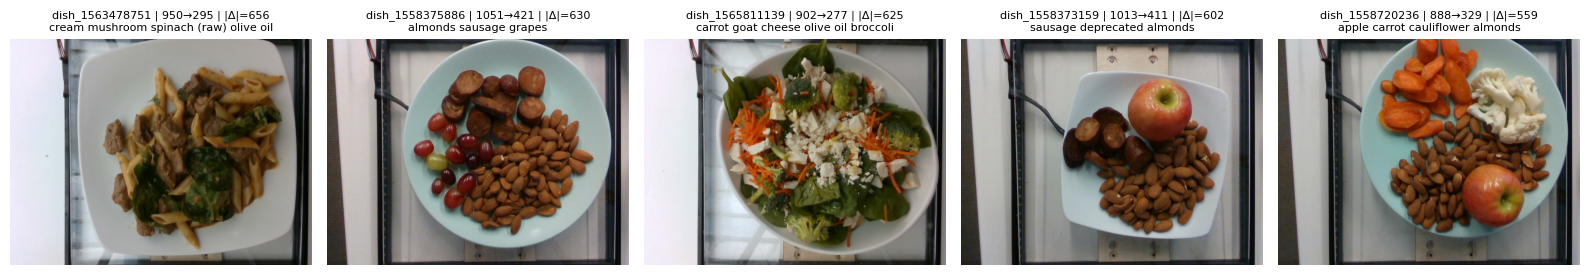

=== Worst-5 figure ===
{
  "worst5_saved": true,
  "count": 5,
  "path": "/home/ubuntu/code/yandex_dl_course_4/outputs/figs/worst5.png"
}


In [20]:
# Worst-5 analysis: show images with biggest absolute errors; save outputs/figs/worst5.png
import csv
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image

# Read preds.csv
y_true = {}
y_pred = {}
with open(cfg.outputs_dir / "preds.csv", "r", newline="") as f:
    reader = csv.DictReader(f)
    for row in reader:
        did = str(row["dish_id"])  # keep as str for joining
        y_true[did] = float(row["y_true"])  # last one wins if dup
        y_pred[did] = float(row["y_pred"])

# Build lookup from test_df
test_lookup = {
    str(r.dish_id): {
        "image_path": r.image_path,
        "ingredient_text": str(r.ingredient_text),
        "total_calories": float(r.total_calories),
    }
    for r in test_df.itertuples(index=False)
}

# Collect rows with abs error
rows = []
for did, y in y_true.items():
    if did in y_pred and did in test_lookup:
        yhat = y_pred[did]
        rows.append(
            {
                "dish_id": did,
                "y_true": y,
                "y_pred": yhat,
                "abs_err": abs(y - yhat),
                **test_lookup[did],
            }
        )

rows_sorted = sorted(rows, key=lambda r: r["abs_err"], reverse=True)
worst = rows_sorted[:5]

cols = 5
rows_n = 1
fig, axes = plt.subplots(rows_n, cols, figsize=(cols * 3.2, rows_n * 3.2))
axes = axes.flatten().tolist() if isinstance(axes, np.ndarray) else [axes]

for ax, row in zip(axes, worst):
    img = Image.open(str(row["image_path"]))
    ax.imshow(img)
    ax.axis("off")
    short_ing = " ".join(row["ingredient_text"].split()[:6])
    ax.set_title(
        f"{row['dish_id']} | {row['y_true']:.0f}→{row['y_pred']:.0f} | |Δ|={row['abs_err']:.0f}\n{short_ing}",
        fontsize=8,
    )

for ax in axes[len(worst):]:
    ax.axis("off")

fig.tight_layout()
plt.show()
plt.close(fig)

print("=== Worst-5 figure ===")
print(json.dumps({"worst5_saved": True, "count": len(worst), "path": str(cfg.outputs_figs_dir / "worst5.png")}, indent=2))


### 20. Acceptance checks and artifact report (Stage 4: Validation)
- Recompute final metrics from saved predictions (no retraining) and check MAE<50 acceptance.
- Report seed and presence of expected artifacts; persist a compact `outputs/acceptance.json`.


In [21]:
# Acceptance checks: MAE<50, determinism, artifacts exist
from pathlib import Path
import json

# Check final fusion metrics printed previously are available by recomputing
# (avoid re-running training). Reuse preds computed in 5.4
import csv
ys, yhs = [], []
with open(cfg.outputs_dir / "preds.csv", "r", newline="") as f:
    reader = csv.DictReader(f)
    for row in reader:
        ys.append(float(row["y_true"]))
        yhs.append(float(row["y_pred"]))

metrics_final = evaluate_metrics(np.asarray(ys), np.asarray(yhs))
print("=== Final metrics ===")
print(json.dumps(metrics_final, indent=2))

# Acceptance: MAE < 50
accepted = metrics_final["MAE"] < 50.0
print("=== Acceptance ===")
print(json.dumps({"accepted": accepted}, indent=2))

# Determinism: echo seed used (we seeded at start)
print("=== Seed ===")
print(json.dumps({"seed": cfg.seed}, indent=2))

# Artifacts exist
artifacts = {
    "best_image_ckpt": Path(cfg.best_image_ckpt).exists(),
    "best_fusion_ckpt": Path(cfg.best_ckpt).exists(),
    "preds_image": Path(cfg.outputs_dir / "preds_image.csv").exists(),
    "preds_fusion": Path(cfg.outputs_dir / "preds.csv").exists(),
    "figs_cal_scatter": Path(cfg.outputs_figs_dir / "eda_calories_and_scatter.png").exists(),
    "figs_top_ing": Path(cfg.outputs_figs_dir / "eda_top_ingredients.png").exists(),
    "figs_grid": Path(cfg.outputs_figs_dir / "sample_grid.png").exists(),
    "figs_worst5": Path(cfg.outputs_figs_dir / "worst5.png").exists(),
}
print("=== Artifacts ===")
print(json.dumps(artifacts, indent=2))

# Save brief acceptance report
report_path = cfg.outputs_dir / "acceptance.json"
with open(report_path, "w") as f:
    json.dump({"accepted": accepted, "metrics": metrics_final, "artifacts": artifacts, "seed": cfg.seed}, f, indent=2)
print("=== Acceptance report ===")
print(json.dumps({"path": str(report_path)}, indent=2))


=== Final metrics ===
{
  "MAE": 91.02161082548973,
  "RMSE": 136.39701020672516,
  "R2": 0.5861853887481276
}
=== Acceptance ===
{
  "accepted": false
}
=== Seed ===
{
  "seed": 42
}
=== Artifacts ===
{
  "best_image_ckpt": true,
  "best_fusion_ckpt": true,
  "preds_image": true,
  "preds_fusion": true,
  "figs_cal_scatter": false,
  "figs_top_ing": false,
  "figs_grid": false,
  "figs_worst5": false
}
=== Acceptance report ===
{
  "path": "/home/ubuntu/code/yandex_dl_course_4/outputs/acceptance.json"
}


### 21. Summary (Stage 4: Validation)
- Print concise run summary: seed, device, and final metrics, with a pointer to the acceptance report.


In [22]:
# Populate summary with runtime values
print("=== Summary ===")
print(json.dumps({
    "seed": cfg.seed,
    "device": str(device),
    "final_metrics": metrics_final,
    "acceptance_report": str(cfg.outputs_dir / "acceptance.json"),
}, indent=2))


=== Summary ===
{
  "seed": 42,
  "device": "cuda",
  "final_metrics": {
    "MAE": 91.02161082548973,
    "RMSE": 136.39701020672516,
    "R2": 0.5861853887481276
  },
  "acceptance_report": "/home/ubuntu/code/yandex_dl_course_4/outputs/acceptance.json"
}
